In [1]:
# March 2022

# for communication

# twitter https://twitter.com/runaz_there

In [2]:
import pandas as pd
import requests
import numpy as np
import seaborn as sns
import pingouin as pg
import re
import nltk
import matplotlib.pyplot as plt

from textblob import TextBlob 
from wordcloud import WordCloud, STOPWORDS
from mlxtend.evaluate import permutation_test

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.metrics import (confusion_matrix, accuracy_score)
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing

Ниже я привожу функцию, которая позволяет взять плейлист, отобрать из него все песни, а затем по каждой песне добавить признаки, предлагаемые API Spotify. Подробнее о том, как эта функция работает, будет в приложении к этой главе. Сейчас же я сосредоточусь на анализе данных, как его можно было бы выполнить с учетом методички. 

Сначала получу данные. Возьму свой публичный плейлист 'Data Science. Reading'. Этот плейлист я создал для чтения книг по Data Science. Вот [ссылка на сам плейлист](https://open.spotify.com/playlist/2BAXTCBCBYrqxrYFil8oBk?si=73d4d884a38145f5&nd=1).

In [3]:
"""
Function to save playlists from Spotify with track information
"""

def get_playlist_tracks(playlist_id, client_id, client_secret):
    CLIENT_ID = client_id
    CLIENT_SECRET = client_secret
    AUTH_URL = 'https://accounts.spotify.com/api/token'

    # POST
    auth_response = requests.post(AUTH_URL, {
    'grant_type': 'client_credentials',
    'client_id': CLIENT_ID,
    'client_secret': CLIENT_SECRET,
    })

    # convert the response to JSON
    auth_response_data = auth_response.json()

    # save the access token

    access_token = auth_response_data['access_token']

    headers = {
    'Authorization': 'Bearer {token}'.format(token=access_token)
    }


    data = []
    BASE_URL = 'https://api.spotify.com/v1/'
    r = requests.get(BASE_URL + 'playlists/' + playlist_id + '/tracks',
                    headers=headers, params={'fields': 'items(track(id, artists(name), name)), total, next'})
    d = r.json()
    total = d['total']
    data.append(d['items'])

    
    if total > 100:
        num_repeat = round((total - 100) / 100)
        if num_repeat > 0:
            num_repeat += 1
            link = d['next']
            if len(link) > 0:
                for i in range(num_repeat):
                    g = requests.get(link, headers=headers)
                    q = g.json()
                    data.append(q['items'])
                    link = q['next']
        if num_repeat == 0:
            link = d['next']
            g = requests.get(link, headers=headers)
            q = g.json()
            data.append(q['items'])
    
    tracks = [item for elem in data for item in elem]

    data_songs = []

    for track in tracks:
        f = requests.get(BASE_URL + 'audio-features/' + track['track']['id'], headers=headers)
        f = f.json()
        f.update({'artist_name': track['track']['artists'][0],
        'id': track['track']['id'],
        'track_name': track['track']['name']})
        
        data_songs.append(f)

    df = pd.DataFrame(data_songs)
    df = df.drop('artist_name', 1).assign(**df.artist_name.dropna().apply(pd.Series))
    df.rename(columns = {'name' : 'artist_name'}, inplace = True)

      
    return df

In [4]:
playlist_id = '2BAXTCBCBYrqxrYFil8oBk'
client_id = 'b6df131e0ead4419aef2fcdbe3311a3c'
client_secret = '13ab7613a8654c7eb532aa95e6931275'


In [5]:
dfg = get_playlist_tracks(playlist_id, client_id, client_secret)
dfg.head(2)

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,type,id,uri,track_href,analysis_url,duration_ms,time_signature,track_name,artist_name
0,0.356,0.3240,7,-8.699,0,0.0289,0.704,0.0025,0.2040,0.438,88.861,audio_features,09g9OlH3RDjbffMAnvBPgw,spotify:track:09g9OlH3RDjbffMAnvBPgw,https://api.spotify.com/v1/tracks/09g9OlH3RDjb...,https://api.spotify.com/v1/audio-analysis/09g9...,166133,4,Summertime,Charlie Parker
1,0.555,0.0255,2,-31.733,1,0.0599,0.986,0.9060,0.0616,0.131,120.281,audio_features,4FsUPnXoCN6VSgkU6wXAwz,spotify:track:4FsUPnXoCN6VSgkU6wXAwz,https://api.spotify.com/v1/tracks/4FsUPnXoCN6V...,https://api.spotify.com/v1/audio-analysis/4FsU...,237000,4,"Orchestral Suite No. 3 in D Major, BWV 1068: I...",Stephan-König-Trio


In [6]:
dfg.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 146 entries, 0 to 145
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   danceability      146 non-null    float64
 1   energy            146 non-null    float64
 2   key               146 non-null    int64  
 3   loudness          146 non-null    float64
 4   mode              146 non-null    int64  
 5   speechiness       146 non-null    float64
 6   acousticness      146 non-null    float64
 7   instrumentalness  146 non-null    float64
 8   liveness          146 non-null    float64
 9   valence           146 non-null    float64
 10  tempo             146 non-null    float64
 11  type              146 non-null    object 
 12  id                146 non-null    object 
 13  uri               146 non-null    object 
 14  track_href        146 non-null    object 
 15  analysis_url      146 non-null    object 
 16  duration_ms       146 non-null    int64  
 1

In [7]:
dfg.to_csv('spotify_playlist_track.csv', index=False)

Опишу каждый признак в соответствии с [официальным руководством](https://developer.spotify.com/documentation/web-api/reference/#/operations/get-several-audio-features).

*danceability* - насколько песня подходит для танцев, с учетом темпа, ритма. Значение ближе к 0 - меньше подходит, значение ближе к 1 - больше подходит.

*energy* - "мера от 0,0 до 1,0 и представляет собой воспринимаемую меру интенсивности и активности. Как правило, энергичные треки кажутся быстрыми, громкими и шумными. Например, дэт-метал обладает высокой энергией, в то время как прелюдия Баха набирает низкие баллы по шкале. Особенности восприятия, влияющие на этот атрибут, включают динамический диапазон, воспринимаемую громкость, тембр, скорость начала и общую энтропию"

*key* - "Ключ, в котором находится трек. Целые числа сопоставляются с высотой тона, используя стандартную нотацию класса высоты тона. Например, 0 = C, 1 = C♯ / D♭, 2 = D и так далее. Если ключ не был обнаружен, значение равно -1".

*loudness* - усредненная по всему треку громкость в децибелах. Обычно значения находятся между -60 и 0.

*mode* - настроение песни, мажорное равно 1, минорное равно 0.

*speechiness* - "Speechiness определяет наличие произносимых слов в треке. Чем больше запись похожа исключительно на речь (например, ток-шоу, аудиокнига, стихи), тем ближе значение атрибута к 1.0. Значения выше 0,66 описывают треки, которые, вероятно, полностью состоят из произносимых слов. Значения от 0,33 до 0,66 описывают треки, которые могут содержать как музыку, так и речь, либо по частям, либо слоями, включая такие случаи, как рэп-музыка. Значения ниже 0,33, скорее всего, представляют собой музыкальные и другие неречевые треки"

*acousticness* - оценивает вероятность того, что трек акустический, чем ближе к 1, тем вероятнее это так.

*instrumentalness* - "Предсказывает, не содержит ли трек вокала. Звуки "Oh" и "aaa" в этом контексте рассматриваются как инструментальные. Рэп или разговорные треки явно "вокальные". Чем ближе значение инструментальности к 1,0, тем больше вероятность того, что трек не содержит вокального контента. Значения выше 0,5 предназначены для представления инструментальных дорожек, но достоверность возрастает по мере приближения значения к 1,0".

*liveness* - "Определяет присутствие аудитории в записи. Более высокие значения живучести представляют собой повышенную вероятность того, что трек был исполнен вживую. Значение выше 0,8 обеспечивает высокую вероятность того, что трек находится в режиме реального времени".

*valence* - "Показатель от 0,0 до 1,0, описывающий музыкальную позитивность, передаваемую треком. Треки с высокой валентностью звучат более позитивно (например, счастливые, жизнерадостные, эйфоричные), в то время как треки с низкой валентностью звучат более негативно (например, грустные, подавленные, злые)".

*tempo* - "Общий предполагаемый темп трека в ударах в минуту (BPM). В музыкальной терминологии темп - это скорость или темп данного произведения, который напрямую зависит от средней продолжительности такта".

*type* - "Допустимое значение: "аудио_функции"".

*id*  - Spotify ID track.

*uri* - Spotify URI track.

*track_href* - "Ссылка на конечную точку веб-API, предоставляющую полную информацию о треке".

*analysis_url* - "A URL to access the full audio analysis of this track. An access token is required to access this data".

*duration_ms* - длительность трека в миллисекундах.

*time_signature* - "Предполагаемая временная сигнатура. Временная сигнатура (метр) - это условное обозначение, определяющее, сколько ударов приходится на каждый такт (или такт). Временная сигнатура колеблется от 3 до 7, указывая на временные сигнатуры от "3/4" до "7/4"".

*track_name* - название трека.

*artist_name* - имя артиста. 

In [8]:
db = pd.read_csv('spotify_playlist_track.csv')
db.head(3)

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,type,id,uri,track_href,analysis_url,duration_ms,time_signature,track_name,artist_name
0,0.356,0.3240,7,-8.699,0,0.0289,0.704,0.0025,0.2040,0.438,88.861,audio_features,09g9OlH3RDjbffMAnvBPgw,spotify:track:09g9OlH3RDjbffMAnvBPgw,https://api.spotify.com/v1/tracks/09g9OlH3RDjb...,https://api.spotify.com/v1/audio-analysis/09g9...,166133,4,Summertime,Charlie Parker
1,0.555,0.0255,2,-31.733,1,0.0599,0.986,0.9060,0.0616,0.131,120.281,audio_features,4FsUPnXoCN6VSgkU6wXAwz,spotify:track:4FsUPnXoCN6VSgkU6wXAwz,https://api.spotify.com/v1/tracks/4FsUPnXoCN6V...,https://api.spotify.com/v1/audio-analysis/4FsU...,237000,4,"Orchestral Suite No. 3 in D Major, BWV 1068: I...",Stephan-König-Trio
2,0.698,0.2780,5,-15.425,1,0.0508,0.572,0.0233,0.1050,0.770,81.079,audio_features,0488kXJ1YnLMrrM1ssJnev,spotify:track:0488kXJ1YnLMrrM1ssJnev,https://api.spotify.com/v1/tracks/0488kXJ1YnLM...,https://api.spotify.com/v1/audio-analysis/0488...,385467,4,Monk's Dream - Take 8,Thelonious Monk


Когда я вижу датафрейм, то у меня смешанные чувства. С одной стороны, мне становится очень интересно, что эти данные могут мне рассказать. С другой стороны, они меня пугают. Слишком много цифр, слишком много... 

Отчасти поэтому я сделал эту методичку. Если следовать методичке, то все становится не таким страшным, а интересные данные действительно удается извлечь. Итак, сначала я должен очистить, подготовить данные. Посмотрю информацию о датафрейме.

In [9]:
db.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 146 entries, 0 to 145
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   danceability      146 non-null    float64
 1   energy            146 non-null    float64
 2   key               146 non-null    int64  
 3   loudness          146 non-null    float64
 4   mode              146 non-null    int64  
 5   speechiness       146 non-null    float64
 6   acousticness      146 non-null    float64
 7   instrumentalness  146 non-null    float64
 8   liveness          146 non-null    float64
 9   valence           146 non-null    float64
 10  tempo             146 non-null    float64
 11  type              146 non-null    object 
 12  id                146 non-null    object 
 13  uri               146 non-null    object 
 14  track_href        146 non-null    object 
 15  analysis_url      146 non-null    object 
 16  duration_ms       146 non-null    int64  
 1

В моих данных 20 переменных и 146 наблюдений. Вот что я собираюсь сделать:

1. удалю те переменные, которые не буду рассматривать в этом исследовании. Поменяю переменные местами, чтобы название песни и имя исполнителя были вначале;
2. проверю правильность названий переменныз, чтобы не было лишних пробелов например;
3. проверю данные на дубликаты;
4. определю, какие переменные являются числовыми, а какие - категориальными.

В чем будет цель исследования? Пускай это будет определение переменной, которая стала решающей при формировании плейлиста, а затем можно научиться ее предсказывать.

Здесь я не буду рассматривать следующие переменные: id, track_href, analysis_url, type. Я удаляю id, но оставляю uri, который содержит тот же id, но иначе оформленный. Если ввести uri в строку поиска Spotify, то можно сразу перейти к треку, что мне пригодится.

In [10]:
# буду работать с копией данных
data = db.copy()

# убираю ненужные переменные
data = data.drop(['id', 'track_href', 'analysis_url', 'type'], axis=1)

# меняю переменные местами
data = data.reindex(columns=['track_name', 'artist_name', 'uri', 'danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness',
       'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo', 'duration_ms', 'time_signature'])

In [11]:
data.head(3)

,track_name,artist_name,uri,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature
0,Summertime,Charlie Parker,spotify:track:09g9OlH3RDjbffMAnvBPgw,0.356,0.3240,7,-8.699,0,0.0289,0.704,0.0025,0.2040,0.438,88.861,166133,4
1,"Orchestral Suite No. 3 in D Major, BWV 1068: I...",Stephan-König-Trio,spotify:track:4FsUPnXoCN6VSgkU6wXAwz,0.555,0.0255,2,-31.733,1,0.0599,0.986,0.9060,0.0616,0.131,120.281,237000,4
2,Monk's Dream - Take 8,Thelonious Monk,spotify:track:0488kXJ1YnLMrrM1ssJnev,0.698,0.2780,5,-15.425,1,0.0508,0.572,0.0233,0.1050,0.770,81.079,385467,4


Теперь, для примера, опишу первый трек, знаменитый Summertime, чтобы понимать, с чем вообще имею дело. С именем исполнителя, названием и uri все ясно (можно запустить этот трек для полного погружения).

danceability показывает, насколько трек подходит для танцев. Здесь речь про вероятность: ближе к 1 - лучше подходит, ближе к 0 - хуже подходит. Summertime подходит плохо.

energy говорит о "быстроте, громкости, шумности" трека. Этот трек находит по середине. Опять-таки имею дело с вероятность. 

key мне, как не музыканту, говорит мало.

loudness - это громкость, однако измеренная в отрицательных децибелах (децибелах затухания). Признаться, мне это ни о чем не говорит.

mode - это настроение. Summertime относится к минору, так как у него 0 по этому признаку. Вот как раз минор и мажор можно и нужно обозначить словами, так как это первый полноценная категориальная переменная. 0 и 1 не измеряют здесь вероятность, это именно признак.

speechiness - это наличие речи. По описанию Spotify совсем нет уверенности, что здесь говорится про вероятность, хотя значения и заданы в диапазоне от 0 до 1. Однако, полагаю, что это все-таки отражает вероятность, а не, скажем, плотность текста в звуке. Значение 0.0289 показывает, что нет почти никакой вероятности, что в треке есть слова. И отсутствие слов подтверждается простым прослушиванием. 

acousticness с вероятностью в 70% трек акустический. Но что это точно означает?

instrumentalness показывает "инструментальность", отсутствие вокала в треке. Здесь показатель 0.0025. Надо полагать, что есть высокая корреляция между этим признаком и speechiness.

liveness показывает наличие "аудитории в записи" или того, что трек был исполнен "вживую". Для Summertime этот показатель составляет 0.2040.

valence показывает позитивность трека. И здесь это 0.438. Насколько коррелирует этот показатель с настроением?

tempo - это темп трека. Здесь это 88.861, что мне, опять-таки как не музыканту, ни о чем не говорит.

duration_ms - длительность трека.

time_signature - метр.

Этот обзор подводит к нескольким интересным вопросам:

1. зависит ли mode от каких-либо признаков? Скажем, длительность песни влияет на ее настроение?
2. зависит ли длительность от какого-то признака?

Надо помнить, что это все я решаю только для данного плейлиста, а не для песен вообще. В тоже время, при прочих равных, можно считать мой плейлист выборкой по джазу, поэтому выводы в какой-то меры можно будет обобщить на джаз вообще. И еще надо помнить, что все-таки главный вопрос - это сущность самого плейлиста, что его определяет.

In [12]:
# проверяю на дубликаты по uri
data.duplicated(subset=['uri']).sum()

0

In [13]:
# заменю 0 и 1 в mode
data['mode'] = np.where(data['mode'] == 0, 'minor', 'major')

In [14]:
# проверю названия переменных
data.columns

Index(['track_name', 'artist_name', 'uri', 'danceability', 'energy', 'key',
       'loudness', 'mode', 'speechiness', 'acousticness', 'instrumentalness',
       'liveness', 'valence', 'tempo', 'duration_ms', 'time_signature'],
      dtype='object')

На этом предварительную подготовку данных можно завершить. Возможно, что дальнейший анализ потребует специальной подготовки, например названий песен. Но пока перейду к статистическому описанию и анализу.

In [15]:
data.describe()

,danceability,energy,key,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature
count,146.000000,146.000000,146.000000,146.000000,146.000000,146.000000,146.000000,146.000000,146.000000,146.000000,146.000000,146.000000
mean,0.481527,0.228030,4.801370,-17.083110,0.043490,0.834203,0.624317,0.162892,0.277882,106.785856,314102.390411,3.808219
std,0.119540,0.178816,3.415219,5.763662,0.021929,0.201169,0.344578,0.172178,0.194884,28.840780,122093.158992,0.459611
min,0.162000,0.001730,0.000000,-40.563000,0.027200,0.041100,0.000012,0.029800,0.039900,54.727000,93307.000000,1.000000
25%,0.396500,0.082325,2.000000,-20.162250,0.034450,0.762500,0.381000,0.095200,0.136000,84.725250,217280.000000,4.000000
50%,0.475000,0.165000,5.000000,-16.641000,0.039550,0.924000,0.825000,0.110000,0.196000,103.718000,292920.000000,4.000000
75%,0.558750,0.330750,7.750000,-13.018000,0.045500,0.967000,0.900250,0.134000,0.387750,120.235000,381980.250000,4.000000
max,0.803000,0.766000,11.000000,-6.872000,0.247000,0.995000,0.966000,0.973000,0.918000,184.943000,714720.000000,5.000000


Метод describe по умолчанию дает характеристику только количественных данных. Поэтому здесь нет данных по mode. Из самой таблицы я получаю описание только для отдельных признаков, про их взаимодействие здечь речь не идет. По сути, приведенные данные по каждому признаку - это характеристики центрального положения признака. 

Итак, опишу свой плейлист по этим признакам. Плейлист явно не танцевальный, так как danceability 0.48, а разброс значений всего 0.12. Самая "танцевальная" песня набирает всего 0.80. 

Плейлист состоит в основном из тихих, не быстрых мелодий. Это показывает energy со средним значением в 0.22. Такая характеристика справедлива для 75% песен, у которых этот показатель в среднем равняется 0.33.

Показатели среднего дл speechiness, acousticness, instrumentalness говорят о том, что плейлист состоит в основном из инструментальных песен. Это справедливо, так как для чтения я отбирал именно такие, без голоса, треки.

Отмечу еще, что треки грустные, на что указывает valence. Продолжительность треков составляет 314102 или 5 минут 23 секунды, что характерно для джаза.

Теперь посмотрю на категориальные признаки.

In [16]:
data[['track_name', 'artist_name', 'mode']].describe()

,track_name,artist_name,mode
count,146,146,146
unique,145,117,2
top,Very Early,Brad Mehldau,major
freq,2,4,89


Из 146 треков уникальных 145, а значит есть трек с одинаковым названием. Его надо найти.

In [17]:
# трек с совпадающим названием
data['track_name'].value_counts().head(1)

Very Early    2
Name: track_name, dtype: int64

In [18]:
data[data['track_name'] == 'Very Early']

,track_name,artist_name,uri,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature
51,Very Early,Charlie Regan Three,spotify:track:7jkBFtRrtzVaWxD9akzRsH,0.327,0.1320,7,-21.502,major,0.0419,0.965,0.890,0.110,0.0665,85.395,226516,3
73,Very Early,Bleecker Jazz Duo,spotify:track:2i6UvEb8X7i2oQTVHah3pV,0.526,0.0872,7,-20.090,major,0.0434,0.984,0.951,0.109,0.0917,92.349,207125,4


Непосредственное прослушивание показывает, что это все-таки две разных композиции, но с одним названием. 

Продолжаю анализ категориальных переменных. Из 146 артистов уникальных только 117. Кто же самый популярный?

In [19]:
data['artist_name'].value_counts().head(5)

Brad Mehldau     4
Louis Hayes      3
Geeder           3
Paolo Fresu      3
Lorenzo Tucci    3
Name: artist_name, dtype: int64

Признаться, для меня это несколько удивительно, но как есть. "Настроений", ясное дело, только два: минор и мажор. Но вот любопытно, что мажорных песен больше всего, целых 89 на 146.

Базовую статистику я получил. Эта статистика касалась только индивидуальных наборов данных. А теперь я хочу что-то узнать и про взаимодействие данных. Сделать это можно с помощью агрегирования и визуализации.

In [20]:
data.groupby(['mode'])[['danceability', 'duration_ms']].mean()

,danceability,duration_ms
mode,,
major,0.482719,306114.460674
minor,0.479667,326574.771930


Агрегирование дает любопытную таблицу. Оказывается, что мажорность или минорность почти не влияет на "танцевальность" музыки. А вот звучат минорные песни несколько дольше.

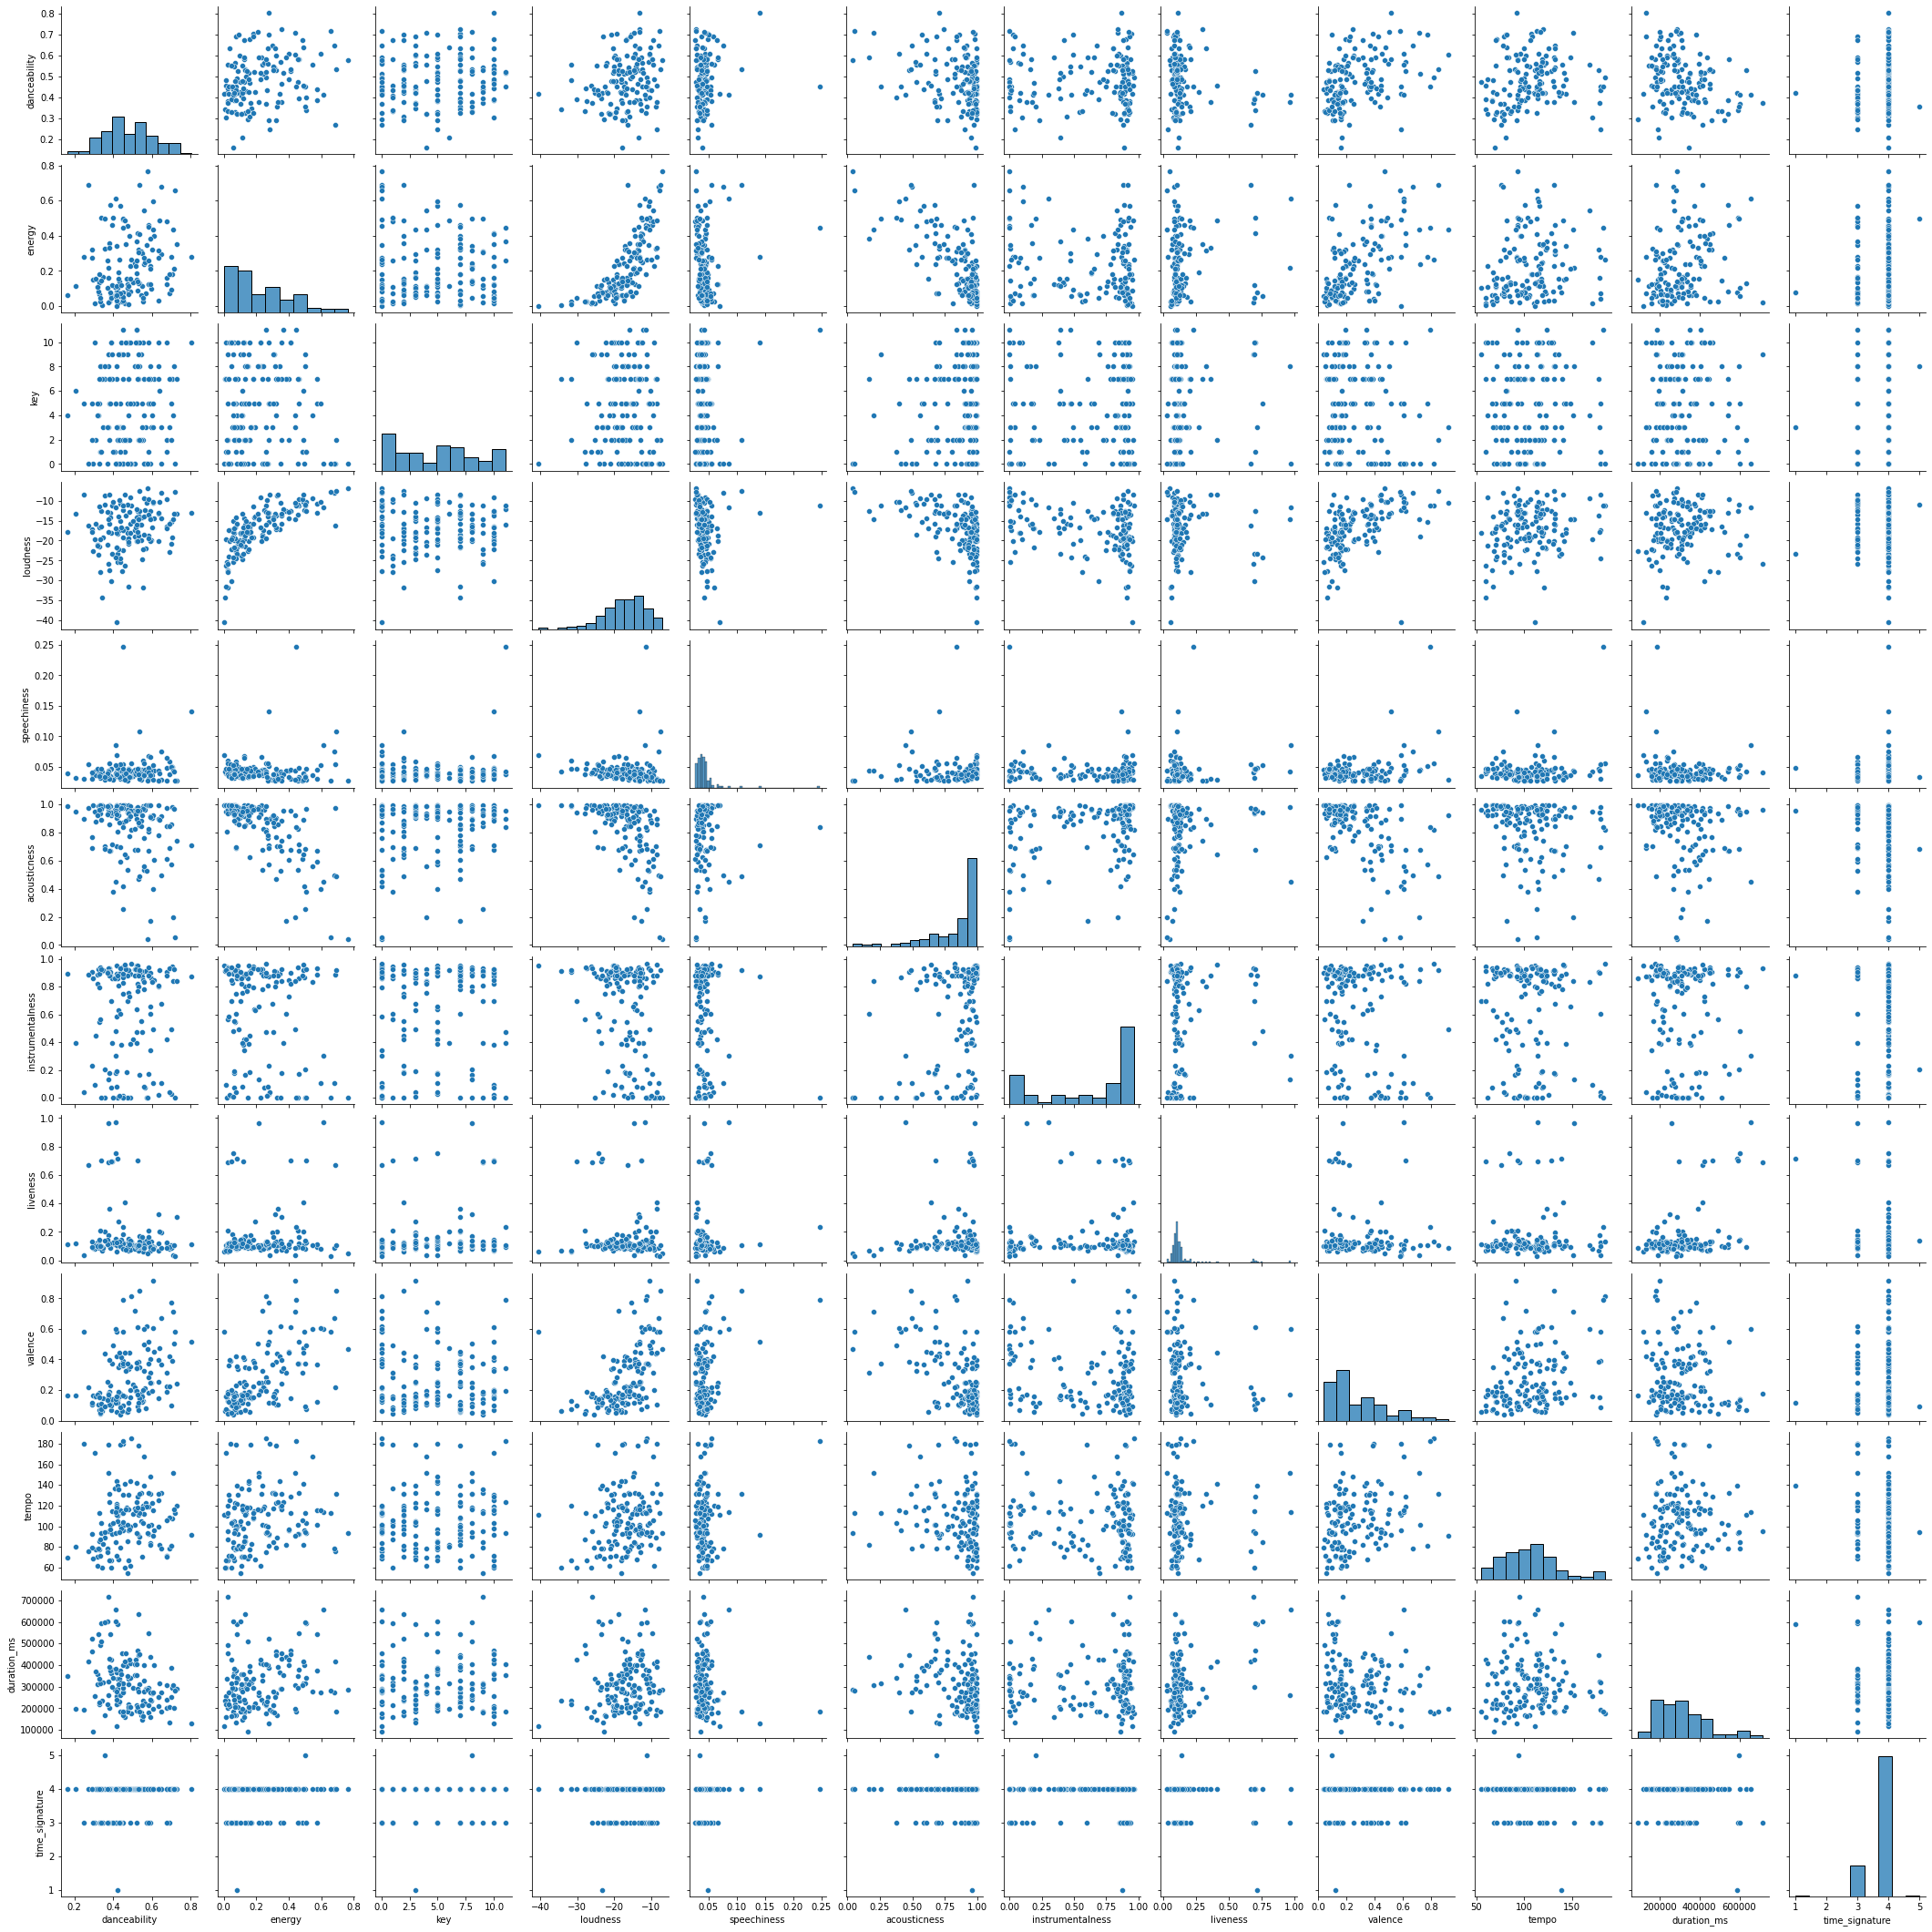

In [21]:
sns.pairplot(data)

Здесь можно "ухватить" несколько любопытных особенностей. Например, energy почти линейно связана с loudness, то есть энергичность с громкостью. Чем более энергичная песня, тем она более громкая. Или чем выше вероятность, что композиция акустическая, тем менее она энергичная.

По этим графикам (по диагонали) видно, что нормального распределения нет ни для одного признака. Сейчас я хочу проверить корреляцию, поэтому, учитывая отсутствие нормального распределения в наборах данных, применю корреляцию по Спирмену. Например, проверю корреляцию между длительностью песни и танцевальностью, громкостью.

In [22]:
pg.pairwise_corr(data, columns=[['duration_ms'], ['danceability', 'loudness']],
                    method='spearman', padjust='bonf')

,X,Y,method,alternative,n,r,CI95%,p-unc,p-corr,p-adjust,power
0,duration_ms,danceability,spearman,two-sided,146,-0.293559,"[-0.44, -0.14]",0.000323,0.000646,bonf,0.952348
1,duration_ms,loudness,spearman,two-sided,146,0.127880,"[-0.04, 0.28]",0.123994,0.247988,bonf,0.338209


Видно, что значимой корреляции нет. В тоже время между длительностью и танцевальностью все-таки есть неплохая отрицательная корреляци, то есть чем длительнее музыка, тем она менее танцевальная и наоборот.

<AxesSubplot:>

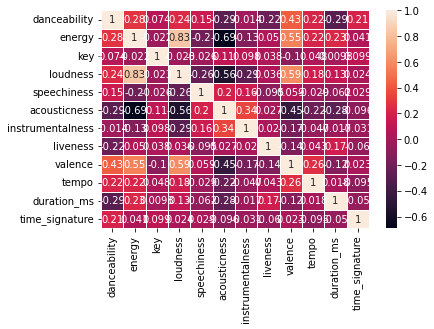

In [23]:
# визуализация корреляции
sns.heatmap(data.corr(method='spearman'), annot=True, linewidths=1)

Здесь представлена корреляция по всем числовым данным. Как и ожидалось, есть значимая корреляция между loudness и energy. Это, пожалуй, самая сильная положительная корреляция. А вот самая сильная отрицательная - между energy и acousticness, что вполне ожидаемо. 

Теперь хорошо было бы провести дисперсионный анализ. Однако не выполняется условие о нормальном распределении признаков. Поэтому воспользуюсь перестановочным тестом. 

In [24]:
mode_p_value = permutation_test(data[data['mode']=='minor']['duration_ms'], data[data['mode']=='major']['duration_ms'],
                    method='approximate', num_rounds=10000, seed=0)
mode_p_value

0.3233676632336766

P-value больше 0.05, поэтому отвергнуть нулевую гипотезу не могу. Значит принимаю альтернативную гипотезу о равенстве средних значений. Из этого следует, что признак mode не влияет на длительность песни.

Теперь проанализирую названия композиций. Прежде всего, удалю скобки, которые, как правило, содержат упоминания о соисполнителях, что и так отражено в artist_name.

In [25]:
data['track_name'] = data['track_name'].str.replace(r"\(.*\)", "")
data['track_name'].head(3)

C:\Users\runaz\AppData\Local\Temp/ipykernel_77580/1005519167.py:1: FutureWarning: The default value of regex will change from True to False in a future version.
  data['track_name'] = data['track_name'].str.replace(r"\(.*\)", "")


0                                           Summertime
1    Orchestral Suite No. 3 in D Major, BWV 1068: I...
2                                Monk's Dream - Take 8
Name: track_name, dtype: object

In [26]:
# проверка на количество уникальных слов в названии
title_list = list(data['artist_name'])
text = ' '.join(title_list)
words = re.findall('\w+', text)
(len(set(words)) / len(words)) * 100

65.85365853658537

Как видно, названия на 65% состоят из уникальных слов. Поближе посмотрю на эти слова.

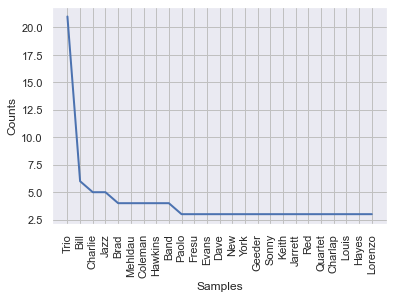

<AxesSubplot:xlabel='Samples', ylabel='Counts'>

In [27]:
sns.set() 
freq = nltk.FreqDist(words)
freq.plot(25)

Интересно еще узнать, а как влияет mode на названия песен.

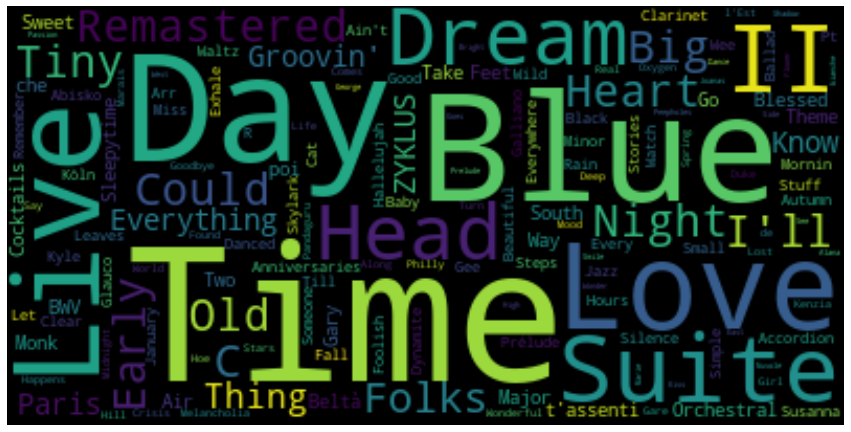

In [28]:
# настроение major
sw = nltk.corpus.stopwords.words('english')
major = data[data['mode'] == 'major']
minor = data[data['mode'] == 'minor']
pos = " ".join(x for x in major['track_name'])
wordcloud1 = WordCloud(stopwords=sw).generate(pos) 
fig, ax = plt.subplots(figsize = (15, 10))
plt.imshow(wordcloud1, interpolation='bilinear')
plt.axis("off")
plt.savefig('wordcloud_major.png')
plt.show()

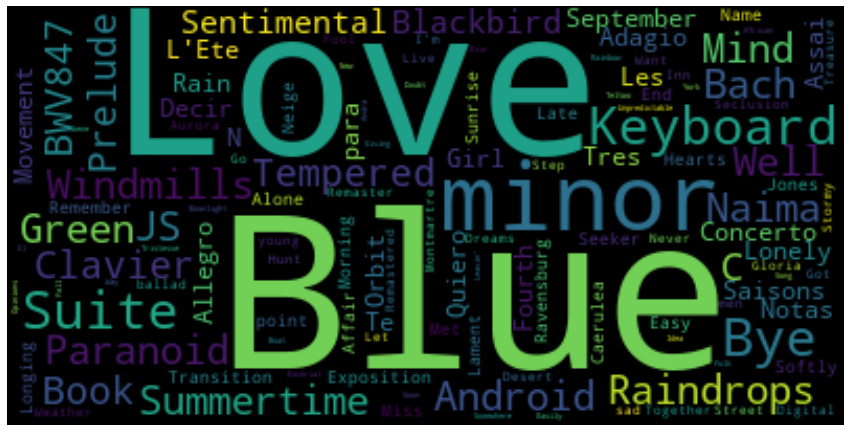

In [29]:
# настроение minor
sw = nltk.corpus.stopwords.words('english')
major = data[data['mode'] == 'major']
minor = data[data['mode'] == 'minor']
pos = " ".join(x for x in minor['track_name'])
wordcloud1 = WordCloud(stopwords=sw).generate(pos) 
fig, ax = plt.subplots(figsize = (15, 10))
plt.imshow(wordcloud1, interpolation='bilinear')
plt.axis("off")
plt.savefig('wordcloud_minor.png')
plt.show()

Теперь я применю линейную регрессию для определения длительности песни, логистическую регрессию для определения настроения, а также проведу классификацию треков по их "близости". Ну и в конце я применю нейронные сети. 

In [30]:
# копия для линейной регрессии
data_lin = data.copy()
data_lin.head(3)

,track_name,artist_name,uri,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature
0,Summertime,Charlie Parker,spotify:track:09g9OlH3RDjbffMAnvBPgw,0.356,0.3240,7,-8.699,minor,0.0289,0.704,0.0025,0.2040,0.438,88.861,166133,4
1,"Orchestral Suite No. 3 in D Major, BWV 1068: I...",Stephan-König-Trio,spotify:track:4FsUPnXoCN6VSgkU6wXAwz,0.555,0.0255,2,-31.733,major,0.0599,0.986,0.9060,0.0616,0.131,120.281,237000,4
2,Monk's Dream - Take 8,Thelonious Monk,spotify:track:0488kXJ1YnLMrrM1ssJnev,0.698,0.2780,5,-15.425,major,0.0508,0.572,0.0233,0.1050,0.770,81.079,385467,4


Зависимой переменной будет duration_ms. Независимые переменные - все остальные, за исключением mode, time_signature, key, uri, artist_name, track_name.

In [31]:
X = data_lin.drop(['mode', 'time_signature', 'key', 'uri', 'artist_name', 'track_name', 'duration_ms'], axis=1)
y = data_lin['duration_ms']
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.6)

In [32]:
X_train

,danceability,energy,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo
141,0.530,0.3060,-14.707,0.0378,0.872,0.87700,0.1050,0.1150,84.222
144,0.607,0.5950,-10.384,0.0530,0.401,0.10300,0.0832,0.6030,115.050
39,0.481,0.0104,-31.641,0.0473,0.995,0.91700,0.0659,0.0748,66.946
60,0.547,0.0608,-19.962,0.0317,0.883,0.55200,0.0952,0.1320,105.068
119,0.727,0.3530,-13.239,0.0273,0.741,0.84200,0.3030,0.2420,120.097
...,...,...,...,...,...,...,...,...,...
67,0.571,0.3490,-10.584,0.0420,0.525,0.00273,0.1400,0.6200,118.673
32,0.602,0.3190,-16.627,0.0360,0.902,0.83300,0.1000,0.1910,122.320
77,0.803,0.2780,-13.015,0.1410,0.706,0.87000,0.1120,0.5150,92.023
108,0.535,0.4090,-12.511,0.0299,0.954,0.89800,0.1340,0.1440,113.063


In [33]:
"""
col_names = ['danceability', 'energy', 'loudness', 'speechiness', 'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo']
features = X_train[col_names]

scaler = StandardScaler().fit(features.values) 
features = scaler.transform(features.values)
X_train[col_names] = features
features_test = X_test[col_names]
features_test = scaler.transform(features_test.values)
X_test[col_names] = features_test
"""

"\ncol_names = ['danceability', 'energy', 'loudness', 'speechiness', 'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo']\nfeatures = X_train[col_names]\n\nscaler = StandardScaler().fit(features.values) \nfeatures = scaler.transform(features.values)\nX_train[col_names] = features\nfeatures_test = X_test[col_names]\nfeatures_test = scaler.transform(features_test.values)\nX_test[col_names] = features_test\n"

In [34]:
# обучаю модель
lin_reg = LinearRegression()
lin_reg.fit(X_train, y_train)

LinearRegression()

In [35]:
# оценка на тренировочных данных
some_data = X_train.iloc[:5]
some_labels = y_train.iloc[:5]
print("Прогноз:", lin_reg.predict(some_data))

Прогноз: [327942.46317374 333218.15019017 233141.71358962 254366.08871874
 313265.90464342]


In [36]:
# а это реальные данные
print('Реальные значения:', list(some_labels))

Реальные значения: [275750, 271565, 217080, 168190, 289113]


In [37]:
# оценка на тестовых данных
# проверка модели с помощью MSE на обучающих данных
X_predict = lin_reg.predict(X_test)
lin_mse = mean_absolute_error(y_test,X_predict)
lin_mse

81140.4568465089

Столь огромное значение ошибки возникает как из-за размера самой ошибки, так и из-за небольшого количества примеров. 

In [38]:
# копия для логистической регреессии
data_log = data.copy()
data_log['mode'] = np.where(data['mode'] == 'minor', 0, 1)
data_log.head(3)

,track_name,artist_name,uri,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature
0,Summertime,Charlie Parker,spotify:track:09g9OlH3RDjbffMAnvBPgw,0.356,0.3240,7,-8.699,0,0.0289,0.704,0.0025,0.2040,0.438,88.861,166133,4
1,"Orchestral Suite No. 3 in D Major, BWV 1068: I...",Stephan-König-Trio,spotify:track:4FsUPnXoCN6VSgkU6wXAwz,0.555,0.0255,2,-31.733,1,0.0599,0.986,0.9060,0.0616,0.131,120.281,237000,4
2,Monk's Dream - Take 8,Thelonious Monk,spotify:track:0488kXJ1YnLMrrM1ssJnev,0.698,0.2780,5,-15.425,1,0.0508,0.572,0.0233,0.1050,0.770,81.079,385467,4


In [39]:
X = data_log.drop(['mode', 'time_signature', 'key', 'uri', 'artist_name', 'track_name'], axis=1)
y = data_log['mode']
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.6)

In [40]:
y_test.value_counts()

1    37
0    22
Name: mode, dtype: int64

Зависимой переменной будет mode. Независимыми будут все остальные переменные, за исключением указанных выше.

In [41]:
logreg = LogisticRegression().fit(X_train, y_train)

In [42]:
predict_log = logreg.predict(X_test) 
confmtrx = np.array(confusion_matrix(y_test, predict_log)) 
data_confus = pd.DataFrame(confmtrx, index=['minor_факт', 'major_факт'], columns=['minor_прогноз', 'major_прогноз']) 
data_confus

,minor_прогноз,major_прогноз
minor_факт,0,22
major_факт,0,37


Даже без дополннительных обследований видно, что прогноз модели довольно часто совпадает с реальностью, но это все-таки неубедительно. Дальнейший анализ это подтверждает.

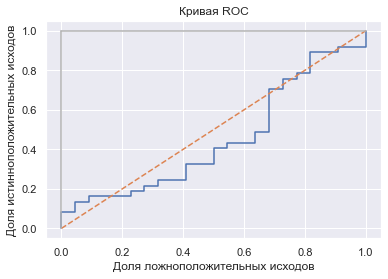

In [43]:
target_probabilities = logreg.predict_proba(X_test)[:, 1]
false_positive_rate, true_positive_rate, threshold = roc_curve(y_test, target_probabilities)
plt.title('Кривая ROC')
plt.plot(false_positive_rate, true_positive_rate)
plt.plot([0, 1], ls='--')
plt.plot([0, 0], [1, 0], c='.7')
plt.plot([1, 1], c='.7')
plt.ylabel('Доля истинноположительных исходов')
plt.xlabel('Доля ложноположительных исходов')
plt.show()

In [44]:
print('AUC на обучающей выборке: {:.3f}'.format(roc_auc_score(y_train, logreg.predict_proba(X_train)[:, 1])))
print('AUC на тестовой выборке: {:.3f}'.format(roc_auc_score(y_test, logreg.predict_proba(X_test)[:, 1])))

AUC на обучающей выборке: 0.476
AUC на тестовой выборке: 0.448


In [45]:
# копия для классификации регреессии
data_clf = data.copy()
data_clf.head(3)

,track_name,artist_name,uri,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature
0,Summertime,Charlie Parker,spotify:track:09g9OlH3RDjbffMAnvBPgw,0.356,0.3240,7,-8.699,minor,0.0289,0.704,0.0025,0.2040,0.438,88.861,166133,4
1,"Orchestral Suite No. 3 in D Major, BWV 1068: I...",Stephan-König-Trio,spotify:track:4FsUPnXoCN6VSgkU6wXAwz,0.555,0.0255,2,-31.733,major,0.0599,0.986,0.9060,0.0616,0.131,120.281,237000,4
2,Monk's Dream - Take 8,Thelonious Monk,spotify:track:0488kXJ1YnLMrrM1ssJnev,0.698,0.2780,5,-15.425,major,0.0508,0.572,0.0233,0.1050,0.770,81.079,385467,4


Для классификации я воспользуюсь не одним из способов из главы 5, а их обобщением TSNE. За основу ниже взят код блогера [Steven Morse](https://stmorse.github.io/journal/spotify-api.html).

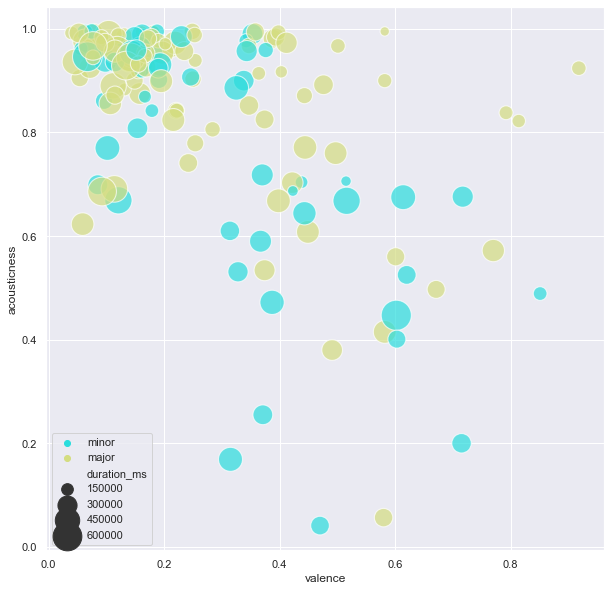

In [46]:
plt.figure(figsize=(10,10))
ax = sns.scatterplot(data=data_clf, x='valence', y='acousticness', 
                     hue='mode', palette='rainbow', 
                     size='duration_ms', sizes=(50,1000), 
                     alpha=0.7)
h,labs = ax.get_legend_handles_labels()
ax.legend(h[1:10], labs[1:10], loc='best', title=None)

Это пример красивого графика, на котором помещается сразу 4 переменных. По оси X идет valence, по оси y идет acousticness. Цветом отмечено настроение песни, а размером - длительность (например 150000 млс равно 2,5 минуты).

In [47]:
# extract relevant columns to numpy array
X = (data_clf
 .filter(['acousticness', 'danceability', 'duration_ms', 'energy',
          'instrumentalness', 'liveness', 'loudness', 'tempo', 'valence'])
)
Xs = StandardScaler().fit_transform(X)

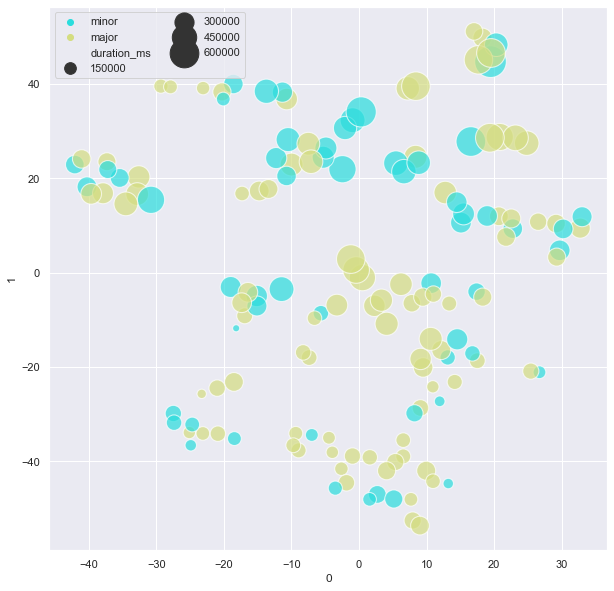

In [48]:
# construct 2-d embedding
tsne = TSNE(n_components=2, perplexity=5, 
    early_exaggeration=2, random_state=3).fit_transform(Xs)

# convert to dataframe for plotting purposes
tsne = pd.DataFrame(tsne)
tsne['mode'] = data_clf['mode']
tsne['duration_ms'] = data_clf['duration_ms']

plt.figure(figsize=(10,10))

ax = sns.scatterplot(data=tsne, x=0, y=1, 
                     hue='mode', palette='rainbow', 
                     size='duration_ms', sizes=(50,1000), 
                     alpha=0.7)

# display legend without `size` attribute
h,labs = ax.get_legend_handles_labels()
ax.legend(h[1:10], labs[1:10], loc='best', ncol=2)

plt.show()

In [49]:
# копия для нейронных сетей
data_dl = data.copy()
data_dl.head(3)

,track_name,artist_name,uri,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature
0,Summertime,Charlie Parker,spotify:track:09g9OlH3RDjbffMAnvBPgw,0.356,0.3240,7,-8.699,minor,0.0289,0.704,0.0025,0.2040,0.438,88.861,166133,4
1,"Orchestral Suite No. 3 in D Major, BWV 1068: I...",Stephan-König-Trio,spotify:track:4FsUPnXoCN6VSgkU6wXAwz,0.555,0.0255,2,-31.733,major,0.0599,0.986,0.9060,0.0616,0.131,120.281,237000,4
2,Monk's Dream - Take 8,Thelonious Monk,spotify:track:0488kXJ1YnLMrrM1ssJnev,0.698,0.2780,5,-15.425,major,0.0508,0.572,0.0233,0.1050,0.770,81.079,385467,4


In [50]:
X = data_log.drop(['time_signature', 'key', 'uri', 'artist_name', 'track_name', 'duration_ms', 'mode'], axis=1)
y = data_log['duration_ms']

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.6)

In [51]:
X_train.head(3)

,danceability,energy,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo
42,0.634,0.0325,-20.179,0.0433,0.993,0.0232,0.0660,0.398,125.293
4,0.458,0.0133,-26.265,0.0400,0.994,0.9440,0.1060,0.161,59.529
3,0.421,0.0162,-25.358,0.0388,0.808,0.0024,0.0978,0.154,110.479


In [52]:
# нормализация
normalizer = preprocessing.Normalization(axis=-1)
normalizer.adapt(np.array(X_train))

In [53]:
# создаю слои
linear_model = tf.keras.Sequential([
    normalizer,
    layers.Dense(64, activation='relu'),
    layers.Dense(64, activation='relu'),
    layers.Dense(64, activation='relu'),
    layers.Dense(64, activation='relu'),
    layers.Dense(64, activation='relu'),
    layers.Dense(64, activation='relu'),
    layers.Dense(1)
])

In [54]:
# компиляция
linear_model.compile(
    optimizer=tf.optimizers.Adam(learning_rate=0.1),  # как подбирать параметры
    loss='mean_absolute_error'  # функция потерь
)

In [55]:
# обучение
history = linear_model.fit(
    X_train, y_train,
    epochs=100,
    verbose=0,
    validation_split=0.2
)

In [56]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

,loss,val_loss,epoch
95,82720.835938,75095.156250,95
96,67459.375000,91541.601562,96
97,52293.281250,73828.960938,97
98,69598.757812,182377.828125,98
99,141114.796875,73206.585938,99


In [57]:
# проверка на тестовом наборе
linear_model.evaluate(X_test, y_test, verbose=0)

105022.1640625

# Приложение Объяснение функции

Ниже я поэтапно покажу и объясню функцию get_playlist_tracks.

In [58]:
playlist_id = '2BAXTCBCBYrqxrYFil8oBk'
client_id = 'b6df131e0ead4419aef2fcdbe3311a3c'
client_secret = '13ab7613a8654c7eb532aa95e6931275'

In [59]:
CLIENT_ID = client_id
CLIENT_SECRET = client_secret
AUTH_URL = 'https://accounts.spotify.com/api/token'

# POST
auth_response = requests.post(AUTH_URL, {
    'grant_type': 'client_credentials',
    'client_id': CLIENT_ID,
    'client_secret': CLIENT_SECRET,
    })

# convert the response to JSON
auth_response_data = auth_response.json()

# save the access token
access_token = auth_response_data['access_token']

headers = {
    'Authorization': 'Bearer {token}'.format(token=access_token)
    }

Код выше работает с данными, которые необходимы для аутентификации в API Spotify. Обнаружить CLIENT_ID и CLIENT_SECRET можно в профиле своего приложения, запустить которое можно [здесь](https://developer.spotify.com/dashboard/applications). 

AUTH_URL - это то "место", через которое я получаю доступ к API. Чтобы в это место попасть, надо предъявить как CLIENT_ID, так и CLIENT_SECRET. Все это делает auth_response, где 'grant_type' дополнительно еще указывает способ авторизации. 

Последующие auth_response_data, access_token и headers просто собирают данные, которые понадобятся для входа в следующий раз. Это просто упрощает жизнь, можно будет ограничиться только headers, а не прописывать все id и пароли.

Теперь я подбираюсь собственно к использованию API. Суть здесь такая: надо отправить на сайт с API Spotify запрос, который будет состоять из базовой части (ее менять уже не надо будет), а также переменной (или нескольких), которые указывают, что собственно я хочу получить от сайта. Эти последние называются точками доступа. Полный перечень таких точек [здесь](https://developer.spotify.com/documentation/web-api/reference/).

Ниже приводится конкретный пример. Так как меня интересуют плейлисты и песни в этих плейлистах, то у меня все выглядит так.

In [60]:
data = []
BASE_URL = 'https://api.spotify.com/v1/'
r = requests.get(BASE_URL + 'playlists/' + playlist_id + '/tracks',
                    headers=headers, params={'fields': 'items(track(id, artists(name), name)), total, next'})
d = r.json()
total = d['total']
data.append(d['items'])

Прежде всего я создаю data, куда буду складывать те данные, которые получу. Дальше указываю базовый адрес, через который буду "заходить" к Spotify.

Запрос **r** означает следующее: я прошу компьютер обратиться к серверу по адресу, который состоит из BASE_URL, а также нескольких последовательных точек входа. Сначала я вхожу в 'playlists/', далее попадаю в нужный мне плейлист через playlist_id, где отыскиваю все треки через '/tracks'. Также я указываю тот самый headers для доступа, а также в params я указываю, что именно о треках конкретного плейлиста я хочу узнать.

После того, как ответ получен, я сохраняю его в d как json. Отдельно забираю из d значение total (сейчас объясню зачем). После чего "закидываю" полученные данные в data.

Почему надо "закидывать" данные в data? Причина таже, по которой я сохраняю total. API возвращает за один проход информацию только о 100 треках (можно указать меньше, но не больше). А у меня в плейлисте может быть и 200 и 300 треков. Вот что бы их все получить я и создал data, а также поэтому мне нужен total. Вот что я с ними буду делать. 

In [61]:
if total > 100:
    num_repeat = round((total - 100) / 100)
    if num_repeat > 0:
        link = d['next']
        if len(link) > 0:
            num_repeat += 1
            for i in range(num_repeat):
                g = requests.get(link, headers=headers)
                q = g.json()
                data.append(q['items'])
                link = q['next']
    if num_repeat == 0:
        link = d['next']
        g = requests.get(link, headers=headers)
        q = g.json()
        data.append(q['items'])
    
tracks = [item for elem in data for item in elem]

Прежде всего, я посчитаю, сколько раз мне надо обратиться к API, чтобы получить все треки. Это считается с помощью num_repeat. Смысл такой: предположим, что треков 196. Тогда первые 100 я уже получил на первом проходе. Остается 96, а если округлить, то 100. Делю на 100 и получаю, что остается выполнить еще один проход.

Далее я прописываю условие, что если num_repeat больше 1, то выполняю цикл, который будет повторяться столько раз, сколько показывает num_repeat. В каждом цикле выполняется уже известный код, данные сохраняются. 

Если же num_repeat меньше 1, то мне достаточно выполнить только еще один проход и сохранить данные. 

Откуда берется tracks? Это необходимо для распаковки данных, без чего дальше не получится их перевести в табличную форму.

In [62]:
data_songs = []

for track in tracks:
    f = requests.get(BASE_URL + 'audio-features/' + track['track']['id'], headers=headers)
    f = f.json()
    f.update({'artist_name': track['track']['artists'][0],
    'id': track['track']['id'],
    'track_name': track['track']['name']})
        
    data_songs.append(f)

Кроме цели получить все песни из конкретного плейлиста, у меня стоит также цель получить все признаки для каждой песни. Этих признаков много, например настроение песни, длина и прочее. Поэтому для каждого track в tracks я опять отправляю запрос на сервер. 

Необычным здесь кажется только f.update. Этот метод как бы сшивает данные из f и данные, которые уже раньше получены для треков.

In [63]:
df = pd.DataFrame(data_songs)
df = df.drop('artist_name', 1).assign(**df.artist_name.dropna().apply(pd.Series))
df.rename(columns = {'name' : 'artist_name'}, inplace = True)    

Теперь осталось создать таблицу.

In [64]:
df.head(3)

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,type,id,uri,track_href,analysis_url,duration_ms,time_signature,track_name,artist_name
0,0.356,0.3240,7,-8.699,0,0.0289,0.704,0.0025,0.2040,0.438,88.861,audio_features,09g9OlH3RDjbffMAnvBPgw,spotify:track:09g9OlH3RDjbffMAnvBPgw,https://api.spotify.com/v1/tracks/09g9OlH3RDjb...,https://api.spotify.com/v1/audio-analysis/09g9...,166133,4,Summertime,Charlie Parker
1,0.555,0.0255,2,-31.733,1,0.0599,0.986,0.9060,0.0616,0.131,120.281,audio_features,4FsUPnXoCN6VSgkU6wXAwz,spotify:track:4FsUPnXoCN6VSgkU6wXAwz,https://api.spotify.com/v1/tracks/4FsUPnXoCN6V...,https://api.spotify.com/v1/audio-analysis/4FsU...,237000,4,"Orchestral Suite No. 3 in D Major, BWV 1068: I...",Stephan-König-Trio
2,0.698,0.2780,5,-15.425,1,0.0508,0.572,0.0233,0.1050,0.770,81.079,audio_features,0488kXJ1YnLMrrM1ssJnev,spotify:track:0488kXJ1YnLMrrM1ssJnev,https://api.spotify.com/v1/tracks/0488kXJ1YnLM...,https://api.spotify.com/v1/audio-analysis/0488...,385467,4,Monk's Dream - Take 8,Thelonious Monk


In [65]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 146 entries, 0 to 145
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   danceability      146 non-null    float64
 1   energy            146 non-null    float64
 2   key               146 non-null    int64  
 3   loudness          146 non-null    float64
 4   mode              146 non-null    int64  
 5   speechiness       146 non-null    float64
 6   acousticness      146 non-null    float64
 7   instrumentalness  146 non-null    float64
 8   liveness          146 non-null    float64
 9   valence           146 non-null    float64
 10  tempo             146 non-null    float64
 11  type              146 non-null    object 
 12  id                146 non-null    object 
 13  uri               146 non-null    object 
 14  track_href        146 non-null    object 
 15  analysis_url      146 non-null    object 
 16  duration_ms       146 non-null    int64  
 1